# Image Segmentation with U-Net
This notebook, adapted from Deeplearning.ai's Deep Learning course, focuses on building a U-Net, a type of Convolutional Neural Network (CNN) designed for quick and precise image segmentation. The U-Net will be used to predict a label for every pixel in an image from a self-driving car dataset.

This type of image classification is known as semantic image segmentation. Similar to object detection, both methods aim to identify the objects present in an image and their locations. However, while object detection uses bounding boxes that may include pixels not part of the object, semantic image segmentation predicts a precise mask for each object by labeling each pixel with its corresponding class. The term "semantic" refers to the content being shown; for example, the "Car" class is represented by a dark blue mask, and the "Person" class is represented by a red mask.
<!-- 
### Semantic Image Segmentation

Semantic image segmentation involves predicting a label for every single pixel in an image, such as those from a self-driving car dataset. 

This technique is a form of image classification where each pixel is labeled with a class, distinguishing it from object detection, which uses bounding boxes to indicate the location of objects. In semantic segmentation, the image is segmented into precise masks, with each object in the image identified by labeling every pixel. For instance, in the example below, the "Car" class is marked with a dark blue mask, and the "Person" class is marked with a red mask: -->

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

For self-driving cars, precise pixel-level labeling is essential for accurately understanding the environment, enabling safe lane changes and avoiding obstacles.

**Objectives:**
- Construct a U-Net model
- Understand the differences between a regular CNN and a U-Net
- Implement semantic image segmentation on the CARLA self-driving car dataset
- Utilize sparse categorical crossentropy for pixel-wise prediction

In [ ]:
# uncomment the following line to install the packages.
# !pip install numpy tensorflow

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

## Load and Split the Data

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

### Explore Unmasked and Masked Images from the Dataset

After completing the exploration, make sure to revert the setting back to `N=2` to avoid a `list index out of range` error from the autograder.


Text(0.5, 1.0, 'Segmentation')

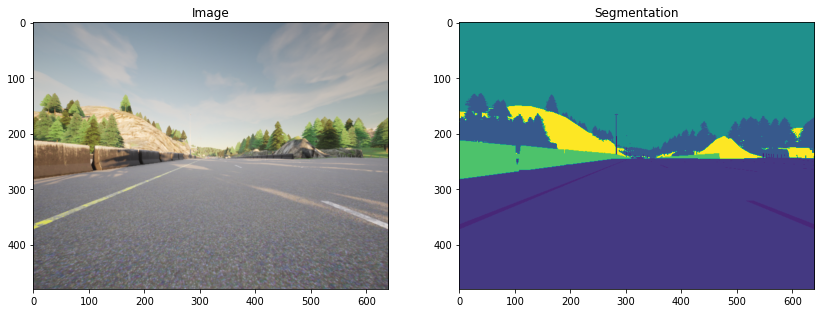

In [3]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### Split the Dataset into Unmasked and Masked Images

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/002128.png', shape=(), dtype=string)


### Preprocess Data

Typically, image values are normalized by dividing by `255`, which scales them to the range `[0, 1]`. However, using `tf.image.convert_image_dtype` with `tf.float32` automatically scales the values to this range, eliminating the need for additional division by `255`.


In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## U-Net 

U-Net, named for its distinctive U-shaped architecture, was first introduced in 2015 for tumor detection but has since become a popular model for various semantic segmentation tasks.

U-Net builds upon the Fully Convolutional Network (FCN) architecture. FCNs replace the dense layers of traditional CNNs with transposed convolution layers that upsample feature maps to the original input size while preserving spatial information. This approach addresses the issue where dense layers typically discard spatial information, which is crucial for image segmentation tasks. Transpose convolutions also allow for variable input sizes, unlike dense layers that require fixed input dimensions.

One limitation of FCNs is that their final feature layer often experiences information loss due to excessive downsampling, which complicates the upsampling process and results in rough outputs.

U-Net enhances the FCN design by incorporating several key modifications. It uses a series of convolutions for downsampling the input image to a feature map and then applies transposed convolutions to upsample the feature maps back to the original image size. Additionally, U-Net introduces skip connections, which transfer information from the downsampling layers to the corresponding upsampling layers. These skip connections help retain detailed information and mitigate information loss during encoding, while also reducing the risk of model overfitting.

### Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b>Figure 2</u></b>: U-Net Architecture<br> </center></caption>

**Contracting Path (Encoder):**

The contracting path begins by passing images through several convolutional layers, which reduce the height and width of the image while increasing the number of channels.

This path follows a standard CNN structure with convolutional layers, activations, and pooling layers to downsample the image and extract features. Specifically, it involves applying two 3x3 convolutions with same padding, each followed by a rectified linear unit (ReLU), and a 2x2 max pooling operation with stride 2 for downsampling. The number of feature channels is doubled at each downsampling step.

**Crop Function:**

The crop function crops the feature maps from the contracting path and concatenates them with the feature maps from the expanding path to form a skip connection.

**Expanding Path (Decoder):**

The expanding path reverses the operations of the contracting path, gradually increasing the image size back to its original dimensions while reducing the number of channels.

Each step in this path involves upsampling the feature map followed by a 2x2 transposed convolution. This upsampling operation doubles the image size while halving the number of feature channels.

Subsequently, the upsampled feature map is concatenated with the cropped feature map from the contracting path, followed by two 3x3 convolutions and a ReLU activation. Cropping is performed to account for the loss of border pixels during convolution.

**Final Feature Mapping Block:**

The final layer uses a 1x1 convolution to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer match the number of filters used, so the 1x1 convolutions adjust this dimension to match the number of classes.

The U-Net network consists of a total of 23 convolutional layers.

#### Key Points:

The figures illustrating the U-Net architecture show dimensions and filter sizes as per the original paper, which utilized smaller images. Due to computational constraints, only half the number of filters will be used. The original dimensions are provided to give a sense of the U-Net architecture. The key takeaway is to use double the number of filters compared to the previous step. The notebook includes detailed instructions and hints for implementing the U-Net architecture.

### Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder consists of multiple conv_blocks:

Each `conv_block()` is made up of 2 **Conv2D** layers with ReLU activations. **Dropout** and **MaxPooling2D** are applied to specific conv_blocks, particularly the last two blocks of the downsampling.

The function returns two tensors: 
- `next_layer`: Feeds into the next block. 
- `skip_connection`: Feeds into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` is the output of the MaxPooling2D layer, while the `skip_connection` is the output of the previous layer (either Conv2D or Dropout, depending on the case). If `max_pooling` is False, both tensors are identical.

### conv_block

Implement `conv_block(...)` with the following steps:

* Add 2 **Conv2D** layers with `n_filters` filters, `kernel_size` set to 3, `kernel_initializer` set to ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` set to 'same', and 'relu' activation.
* If `dropout_prob` > 0, add a Dropout layer with the parameter `dropout_prob`.
* If `max_pooling` is True, add a MaxPooling2D layer with a 2x2 pool size.

In [7]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,         # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,         # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)      
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [8]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
comparator(summary(model2), output2)

Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
All tests passed!

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
All tests passed!


### Decoder (Upsampling Block)

The decoder, or upsampling block, restores the features to the original image size. At each upsampling level, the output of the corresponding encoder block is concatenated before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

The decoder includes two new components: `up` and `merge`. These are the transpose convolution and the skip connections. Additionally, two more convolutional layers are set to the same parameters as in the encoder.

The `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer, is also used in the decoder. More details about it can be found [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)

### upsampling_block

For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer).
* Uses the same number of filters as in the downsampling block completed previously.
* The `Conv2DTranspose` layer takes `n_filters` with a shape of (3,3), a stride of (2,2), and padding set to `same`. It's applied to `expansive_input`, the input tensor from the previous layer.

This block is also where the outputs from the encoder blocks are concatenated, creating skip connections. 

* Concatenate the Conv2DTranspose layer output with the contractive input, using an `axis` of 3. For the grader, it is important to use `[up, contractive_input]`.

For the final component, set the parameters for two Conv2D layers to the same values used for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding).

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,            # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                  3,           # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters,   # Number of filters
                  3,           # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

In [10]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


### Build the Model

This is where it all comes together by chaining the encoder, bottleneck, and decoder. The number of output channels for this model is 23, corresponding to the 23 possible labels for each pixel in the self-driving car dataset.

### unet_model

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a `conv_block` that takes the inputs of the model and the specified number of filters.
* Chain the first output element of each block to the input of the next convolutional block.
* Double the number of filters at each step.
* Starting with `conv_block4`, add `dropout_prob` of 0.3.
* For the final `conv_block`, set `dropout_prob` to 0.3 again, and turn off max pooling.

For the second half:

* Use `cblock5` as `expansive_input` and `cblock4` as `contractive_input`, with `n_filters` * 8. This forms the bottleneck layer.
* Chain the output of the previous block as `expansive_input` and the corresponding contractive block output.
* Ensure the use of the second element of the contractive block before the max pooling layer.
* At each step, use half the number of filters of the previous block.
* `conv9` is a `Conv2D` layer with ReLU activation, He normal initializer, and `same` padding.
* Finally, `conv10` is a `Conv2D` that takes the number of classes as the filter, a kernel size of 1, and `same` padding. The output of `conv10` is the output of the model.

In [13]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
comparator(summary(unet), outputs.unet_model_output)


All tests passed!


<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [15]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Model Summary! 

In [16]:
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_46 (Conv2D)             (None, 96, 128, 32)  896         ['input_7[0][0]']                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_46[0][0]']              
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 48, 64, 32)  0           ['conv2d_47[0][0]']        

                                                                                                  
 conv2d_65 (Conv2D)             (None, 96, 128, 23)  759         ['conv2d_64[0][0]']              
                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


### Loss Function

In semantic segmentation, each mask corresponds to a different object class. In the dataset being used, each pixel in every mask has a single integer probability, indicating its class from 0 to `num_classes-1`. The correct class for a pixel is determined by the highest probability.

Unlike categorical crossentropy, which requires one-hot encoded labels (composed of 0s and 1s), sparse categorical crossentropy is used here as the loss function for pixel-wise multiclass prediction. This is more efficient for handling numerous classes.

In [17]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Dataset Handling

A function that displays both an input image and its corresponding ground truth mask is defined below. The ground truth mask represents the ideal output that the trained model strives to approximate.

In [18]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


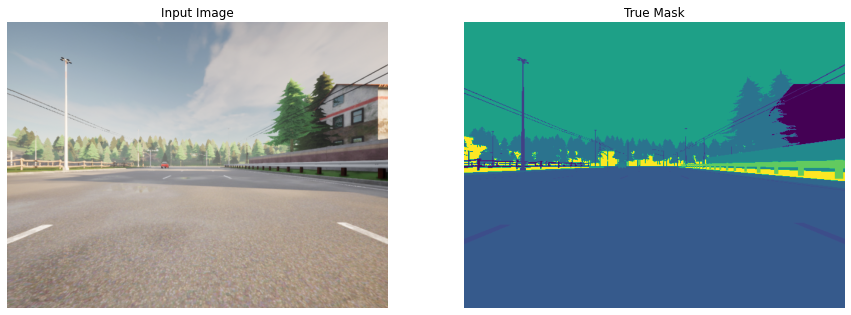

In [19]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


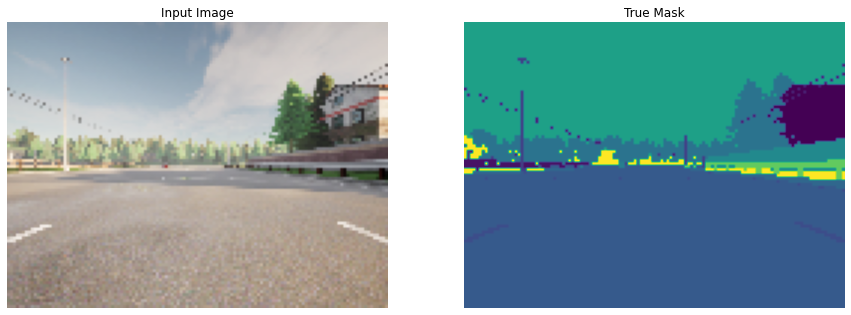

In [20]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## Train the Model

In [21]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 18s 187ms/step - loss: 1.7283 - accuracy: 0.5379
Epoch 2/5
34/34 [==============================] - 2s 47ms/step - loss: 0.6928 - accuracy: 0.8132
Epoch 3/5
34/34 [==============================] - 2s 47ms/step - loss: 0.5065 - accuracy: 0.8522
Epoch 4/5
34/34 [==============================] - 2s 47ms/step - loss: 0.4254 - accuracy: 0.8763
Epoch 5/5
34/34 [==============================] - 2s 47ms/step - loss: 0.3659 - accuracy: 0.8899


### Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

### Plot Model Accuracy

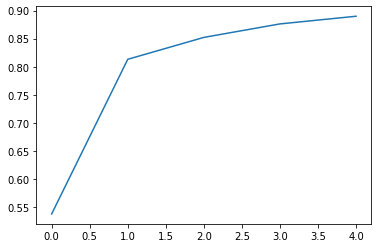

In [23]:
plt.plot(model_history.history["accuracy"])

### Show Predictions 

Next, check the predicted masks against the true mask and the original input image:

In [25]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 213ms/step


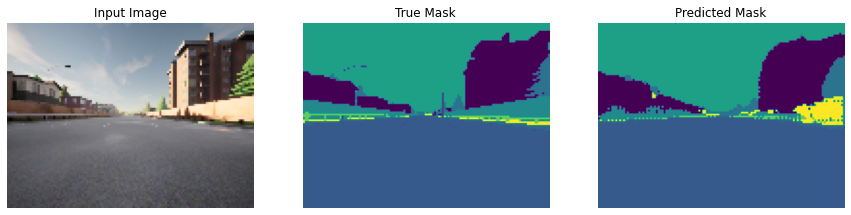

1/1 [==============================] - 0s 20ms/step


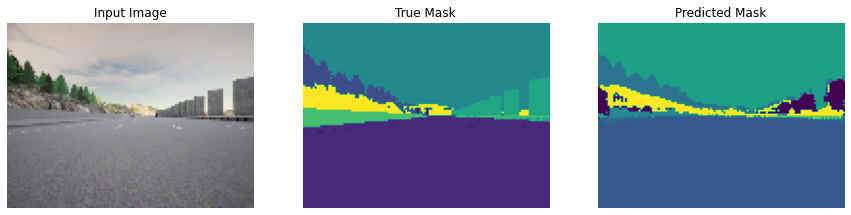

1/1 [==============================] - 0s 20ms/step


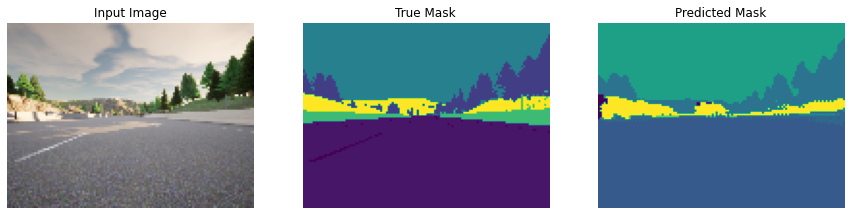

1/1 [==============================] - 0s 21ms/step


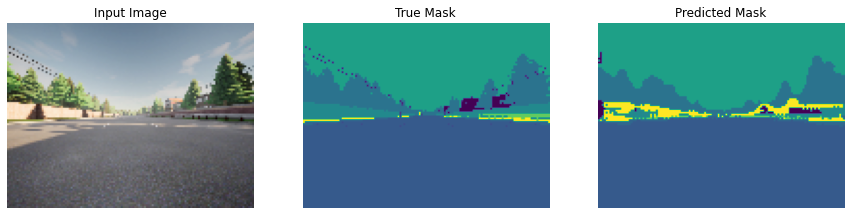

1/1 [==============================] - 0s 20ms/step


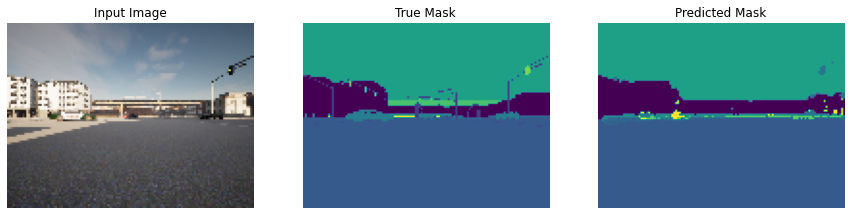

1/1 [==============================] - 0s 20ms/step


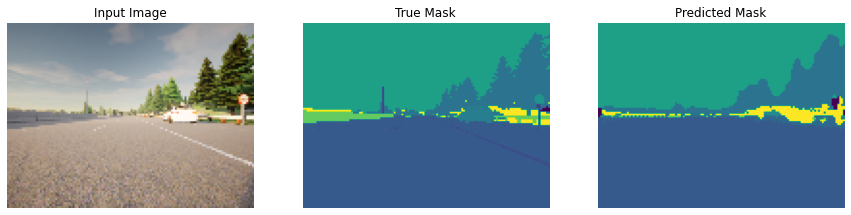

In [26]:
show_predictions(train_dataset, 6)

With 40 epochs we get amazing results!


**Recap**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net